In [20]:
import json

import pandas as pd
import requests as req
import spacy
from bs4 import BeautifulSoup
from nltk.stem.porter import *
from tqdm.notebook import tqdm

In [22]:
# making it look like we are browsing from iPad, in case it helps bypass some bot detection
HEADERS = {'User-Agent': 'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148'}

# pulling latest sitemap
with open('../data/raw/accenture/blogs-sitemap.xml', 'w+') as f:
    r = req.get('https://www.accenture.com/wordpressblogs-sitemap.xml', headers=HEADERS)
    f.write(r.text)

In [27]:
links = []
with open('../data/raw/accenture/blogs-sitemap.xml') as f:
    map_soup = BeautifulSoup(f.read())
    for loc in map_soup.find_all('loc', recursive=True):
        # scraping only English-language blogs;
        # ignoring blog-index
        
        if '-en/blogs' in loc.text:
            links.append(loc.text)

df = []
for link in links:
    # using regex to extract meaningful part of the link and language of the blog
    stem = re.search(r'-en(\/.*)$', link).group(1)
    lang = re.search(r'accenture.com\/(.+?)\/', link).group(1)
    
    df.append({
        'link': link,
        'stem': stem,
        'lang': lang
    })

df = pd.DataFrame(df)
# dropping pages duplicated in several locales
df = df.drop_duplicates(subset=['stem']).drop(columns='stem')
print(len(df), 'links')
df['lang'].value_counts()

423 links


lang
us-en    320
au-en     38
gb-en     26
sg-en     14
in-en     10
nl-en      9
no-en      3
ch-en      2
fi-en      1
Name: count, dtype: int64

### Fetching text from each link (~10 min)

In [28]:
if 'text' not in df.columns.values:
    df['text'] = None
if 'status' not in df.columns.values:
    df['status'] = None
if 'title' not in df.columns.values:
    df['title'] = None
if 'date' not in df.columns.values:
    df['date'] = None

# using tqdm for the progress bar in notebook output
for i, row in tqdm(df.iterrows(), total=len(df)):
    r = req.get(row['link'], headers=HEADERS)
    status = str(r.status_code)
    if r.status_code == 200:
        soup = BeautifulSoup(r.text)
        title = soup.find(attrs={'class': 'rad-article-hero__headline'})
        if title:
            title = title.get_text(" ")
        df.at[i, 'title'] = title
            
        date = soup.find(attrs={'class': 'rad-article-hero__publish-date'})
        if date:
            date = date.text
        df.at[i, 'date'] = date
            
        # ignoring text blocks about quotes and authors
        text = '\n'.join([el.get_text(" ") for el in soup.find_all(attrs={'class': 'text'})])

        df.at[i, 'text'] = text

    df.at[i, 'status'] = status

backup_df = df
df

  0%|          | 0/423 [00:00<?, ?it/s]

,link,lang,text,status,title,date
0,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n How generative AI will transform your wo...,200,None,None
1,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n Anyone else remember the days of prin...,200,5 tips for interview success,None
2,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n View the video on Youtube \n Technolo...,200,Raise your cloud technology IQ,"July 22, 2021"
3,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n The interview experience has evolved ...,200,9 ways to perfect your video interview,"May 10, 2022"
4,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n The great migration to cloud continue...,200,The Cloud Continuum unleashes new career oppor...,"December 14, 2021"
...,...,...,...,...,...,...
861,https://www.accenture.com/sg-en/blogs/southeas...,sg-en,\n \n \n A young project manager’s phone light...,200,The possibilities of the metaverse,"June 20, 2022"
863,https://www.accenture.com/sg-en/blogs/future-c...,sg-en,"\n \n \n Sometimes, all it takes is a single a...",200,Harnessing the power of digital twins in cyber...,"September 08, 2022"
868,https://www.accenture.com/sg-en/blogs/southeas...,sg-en,"\n \n \n Across the internet, in both paid and...",200,How businesses can avoid the dark side of AI,"December 05, 2022"
871,https://www.accenture.com/sg-en/blogs/southeas...,sg-en,"\n \n \n As we headed into 2022, many organisa...",200,How ASEAN SMEs are reshaping their businesses ...,"October 05, 2022"


In [42]:
df = df.drop_duplicates(subset=['text', 'title'])
df['date'] = pd.to_datetime(df['date'], format='%B %d, %Y')
df = df[df['status'] == '200'][df['date'].notna()].drop(columns=['status'])
df = df.reset_index(drop=True)

df

,link,lang,text,title,date,stemmed
0,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n View the video on Youtube \n Technolo...,Raise your cloud technology IQ,2021-07-22,view the video on youtub \n technolog continu...
1,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n The interview experience has evolved ...,9 ways to perfect your video interview,2022-05-10,the interview experi ha evolv in today ’s conn...
2,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n The great migration to cloud continue...,The Cloud Continuum unleashes new career oppor...,2021-12-14,the great migrat to cloud continu to acceler ....
3,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n There’s been a dramatic shift in the ...,7 in-demand entry-level skills and traits,2022-08-12,there ’s been a dramat shift in the world of w...
4,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n I have reviewed countless resumes thr...,4 ways to help your resume stand out,2022-08-01,i have review countless resum throughout my re...
...,...,...,...,...,...,...
398,https://www.accenture.com/sg-en/blogs/southeas...,sg-en,\n \n \n A young project manager’s phone light...,The possibilities of the metaverse,2022-06-20,a young project manag ’s phone light up . it ’...
399,https://www.accenture.com/sg-en/blogs/future-c...,sg-en,"\n \n \n Sometimes, all it takes is a single a...",Harnessing the power of digital twins in cyber...,2022-09-08,"sometim , all it take is a singl attack on a s..."
400,https://www.accenture.com/sg-en/blogs/southeas...,sg-en,"\n \n \n Across the internet, in both paid and...",How businesses can avoid the dark side of AI,2022-12-05,"across the internet , in both paid and free ve..."
401,https://www.accenture.com/sg-en/blogs/southeas...,sg-en,"\n \n \n As we headed into 2022, many organisa...",How ASEAN SMEs are reshaping their businesses ...,2022-10-05,"as we head into 2022 , mani organis were gear ..."


### Stemming

Run this in terminal to download the spacy model used (or skip the next cell).

`python -m spacy download en_core_web_sm`

In [51]:
nlp = spacy.load('en_core_web_sm')
stemmer = PorterStemmer()

# Stemming ignores punctuation and linebreaks.
def stem_text(text):
    tokens = []
    # correcting the weird apostrophe used in Accenture texts
    for token in nlp(str(text).replace('’', '\'')):
        if not token.is_punct and not token.is_space:
            tokens.append(stemmer.stem(token.text))
    return ' '.join(tokens)

df['stemmed'] = df['text'].apply(stem_text)
df

,link,lang,text,title,date,stemmed
0,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n View the video on Youtube \n Technolo...,Raise your cloud technology IQ,2021-07-22,view the video on youtub technolog continu to ...
1,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n The interview experience has evolved ...,9 ways to perfect your video interview,2022-05-10,the interview experi ha evolv in today 's conn...
2,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n The great migration to cloud continue...,The Cloud Continuum unleashes new career oppor...,2021-12-14,the great migrat to cloud continu to acceler t...
3,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n There’s been a dramatic shift in the ...,7 in-demand entry-level skills and traits,2022-08-12,there 's been a dramat shift in the world of w...
4,https://www.accenture.com/us-en/blogs/blogs-ca...,us-en,\n \n \n I have reviewed countless resumes thr...,4 ways to help your resume stand out,2022-08-01,i have review countless resum throughout my re...
...,...,...,...,...,...,...
398,https://www.accenture.com/sg-en/blogs/southeas...,sg-en,\n \n \n A young project manager’s phone light...,The possibilities of the metaverse,2022-06-20,a young project manag 's phone light up it 's ...
399,https://www.accenture.com/sg-en/blogs/future-c...,sg-en,"\n \n \n Sometimes, all it takes is a single a...",Harnessing the power of digital twins in cyber...,2022-09-08,sometim all it take is a singl attack on a sup...
400,https://www.accenture.com/sg-en/blogs/southeas...,sg-en,"\n \n \n Across the internet, in both paid and...",How businesses can avoid the dark side of AI,2022-12-05,across the internet in both paid and free vers...
401,https://www.accenture.com/sg-en/blogs/southeas...,sg-en,"\n \n \n As we headed into 2022, many organisa...",How ASEAN SMEs are reshaping their businesses ...,2022-10-05,as we head into 2022 mani organis were gear up...


In [54]:
df.to_csv('../data/raw/accenture/pages.csv', mode='w', index=False)
# df = pd.read_csv('../data/raw/accenture/pages.csv')

In [3]:
df = pd.read_csv('../data/processed/futurice/blogs_with_analytics.csv')

In [4]:
df

,link,title,date,category,grid paragraph,headings,content paragraph,bullets,total users,new users,returning users,views,views per session,sessions,average session duration,bounce rate
0,https://futurice.com/blog/designops-small-team...,DesignOps - Small team starter guide,5 Sept 2023,Technology,DesignOps is a powerful framework that works f...,"['Index', 'Intro', 'What we mean by ‘DesignOps...",['The conversation about DesignOps seems to fo...,"['Intro', ""What we mean by ‘DesignOps'"", 'Clar...",6.0,0.0,4.0,9.0,0.642857,14.0,156.692704,0.928571
1,https://futurice.com/blog/european-accessibili...,Navigating the European Accessibility Act,30 Aug 2023,Strategy,Digital accessibility is soon to be mandatory ...,"['This is digital accessibility in short', 'Wh...",['The European Union is determined to help its...,"['Computers and operating systems', 'ATMs, tic...",27.0,13.0,12.0,54.0,0.720000,75.0,522.475715,0.853333
2,https://futurice.com/blog/group-decision-makin...,"Practical tips for facilitating high-quality, ...",21 Aug 2023,Strategy,This article helps you recognize the most comm...,"['Group decision-making challenges', 'Solution...",['If you want to empower your management team ...,['An overly optimistic idea of what can be don...,76.0,34.0,43.0,150.0,0.663717,226.0,140.181343,0.902655
3,https://futurice.com/blog/futustories-from-con...,Better late than never – Sander’s shift from c...,11 Aug 2023,Culture,"From consulting to coding, discover Sander Nob...","['How did you end up working at Futurice?', 'W...",['When a previous employer’s office closure an...,[],17.0,6.0,7.0,30.0,0.697674,43.0,127.233857,0.813953
4,https://futurice.com/blog/car-companion-apps,Car companion apps - the tip of the automotive...,21 Jul 2023,Technology,Many car manufacturers are missing the market ...,['So what is it that MyBMW and Mini apps do to...,"['Today, every major auto manufacturer offers ...",['Mindset of traditional OEMs: I am generalisi...,76.0,43.0,35.0,137.0,0.628440,218.0,130.211249,0.770642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,https://futurice.com/blog/futurice-europes-bes...,Futurice – Europe's best workplace,7 Jun 2012,Culture,Wow! A great continuation for the national pri...,[],['Wow! A great continuation for the national p...,[],17.0,7.0,6.0,19.0,0.730769,26.0,138.922882,0.769231
508,https://futurice.com/blog/you-must-be-somewher...,You must be somewhere in London,30 May 2012,Culture,Time goes fast in London. You wake up in the m...,[],"['Time goes fast in London.', 'You wake up in ...",[],4.0,0.0,0.0,3.0,0.750000,4.0,4.195911,1.000000
509,https://futurice.com/blog/decision-making-at-f...,Decision making at Futurice,7 May 2012,Culture,Futurice is a company with a flat hierarchy an...,[],"['', ""Futurice is a company with a flat hierar...",[],199.0,126.0,79.0,283.0,0.736979,384.0,142.158630,0.671875
510,https://futurice.com/blog/designing-and-buildi...,Designing and building apps for four platforms...,17 Feb 2012,Projects,"A couple of weeks ago, together with Restauran...",[],"['A couple of weeks ago, together with [Restau...",[],5.0,0.0,2.0,5.0,0.714286,7.0,15.107210,1.000000


<Axes: xlabel='date'>

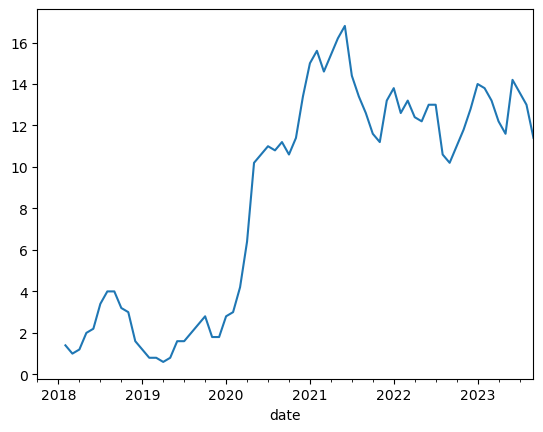

In [14]:
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
df.groupby(pd.Grouper(key='date', freq='1M')).count()['link'].rolling(5).mean().plot()

In [40]:
df = pd.read_csv('../data/processed/futurice/blogs_with_analytics.csv')
df

,link,title,date,category,grid paragraph,headings,content paragraph,bullets,total users,new users,returning users,views,views per session,sessions,average session duration,bounce rate
0,https://futurice.com/blog/designops-small-team...,DesignOps - Small team starter guide,5 Sept 2023,Technology,DesignOps is a powerful framework that works f...,"['Index', 'Intro', 'What we mean by ‘DesignOps...",['The conversation about DesignOps seems to fo...,"['Intro', ""What we mean by ‘DesignOps'"", 'Clar...",6.0,0.0,4.0,9.0,0.642857,14.0,156.692704,0.928571
1,https://futurice.com/blog/european-accessibili...,Navigating the European Accessibility Act,30 Aug 2023,Strategy,Digital accessibility is soon to be mandatory ...,"['This is digital accessibility in short', 'Wh...",['The European Union is determined to help its...,"['Computers and operating systems', 'ATMs, tic...",27.0,13.0,12.0,54.0,0.720000,75.0,522.475715,0.853333
2,https://futurice.com/blog/group-decision-makin...,"Practical tips for facilitating high-quality, ...",21 Aug 2023,Strategy,This article helps you recognize the most comm...,"['Group decision-making challenges', 'Solution...",['If you want to empower your management team ...,['An overly optimistic idea of what can be don...,76.0,34.0,43.0,150.0,0.663717,226.0,140.181343,0.902655
3,https://futurice.com/blog/futustories-from-con...,Better late than never – Sander’s shift from c...,11 Aug 2023,Culture,"From consulting to coding, discover Sander Nob...","['How did you end up working at Futurice?', 'W...",['When a previous employer’s office closure an...,[],17.0,6.0,7.0,30.0,0.697674,43.0,127.233857,0.813953
4,https://futurice.com/blog/car-companion-apps,Car companion apps - the tip of the automotive...,21 Jul 2023,Technology,Many car manufacturers are missing the market ...,['So what is it that MyBMW and Mini apps do to...,"['Today, every major auto manufacturer offers ...",['Mindset of traditional OEMs: I am generalisi...,76.0,43.0,35.0,137.0,0.628440,218.0,130.211249,0.770642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,https://futurice.com/blog/futurice-europes-bes...,Futurice – Europe's best workplace,7 Jun 2012,Culture,Wow! A great continuation for the national pri...,[],['Wow! A great continuation for the national p...,[],17.0,7.0,6.0,19.0,0.730769,26.0,138.922882,0.769231
508,https://futurice.com/blog/you-must-be-somewher...,You must be somewhere in London,30 May 2012,Culture,Time goes fast in London. You wake up in the m...,[],"['Time goes fast in London.', 'You wake up in ...",[],4.0,0.0,0.0,3.0,0.750000,4.0,4.195911,1.000000
509,https://futurice.com/blog/decision-making-at-f...,Decision making at Futurice,7 May 2012,Culture,Futurice is a company with a flat hierarchy an...,[],"['', ""Futurice is a company with a flat hierar...",[],199.0,126.0,79.0,283.0,0.736979,384.0,142.158630,0.671875
510,https://futurice.com/blog/designing-and-buildi...,Designing and building apps for four platforms...,17 Feb 2012,Projects,"A couple of weeks ago, together with Restauran...",[],"['A couple of weeks ago, together with [Restau...",[],5.0,0.0,2.0,5.0,0.714286,7.0,15.107210,1.000000


In [41]:
def get_full_text():
    import ast
    def get_text(row):
        return " ".join(ast.literal_eval(row[6])) + " " + \
                " ".join(ast.literal_eval(row[7]))
    df['text'] = df.apply(get_text, axis=1)
    df = df.rename(columns={'text': 'full text'})
    # df.to_csv('../data/processed/futurice/blogs_with_analytics.csv', mode='w+', index=False)


In [45]:
def generate_stemmed_texts():
    # python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')
    stemmer = PorterStemmer()
    
    # Stemming ignores punctuation and linebreaks.
    def stem_text(text):
        tokens = []
        # correcting the weird apostrophe used in Accenture texts
        for token in nlp(str(text).replace('’', '\'')):
            if not token.is_punct and not token.is_space:
                tokens.append(stemmer.stem(token.text))
        return ' '.join(tokens)
    
    names = ['Accenture', 'Futurice', 'Tietoevry']
    paths = ['../data/raw/accenture/pages.csv', '../data/processed/futurice/blogs_with_analytics.csv', '../data/raw/tietoevry/blogs.csv']
    
    dest_paths = ['../data/processed/stemmed/accenture.csv', '../data/processed/stemmed/futurice.csv', '../data/processed/stemmed/tietoevry.csv']
    
    dfs = []
    for i in tqdm(range(len(names))):
        df = pd.read_csv(paths[i])
        if 'text' in df.columns:
            df = df[['date', 'text']]
        elif 'full text' in df.columns:
            df = df[['date', 'full text']].rename(columns={'full text': 'text'})
        else:
            raise Exception('no text')
    
        df.name = names[i]
        df['date'] = pd.to_datetime(df['date'], format='mixed')  # detects format itself
        df['stemmed'] = df['text'].apply(stem_text)
        df.to_csv(dest_paths[i], index=False, mode='x+')

  0%|          | 0/3 [00:00<?, ?it/s]

In [48]:
df = pd.read_csv('../data/processed/stemmed/futurice.csv')

In [49]:
df

,date,text,stemmed
0,2023-09-05,The conversation about DesignOps seems to focu...,the convers about designop seem to focu on lar...
1,2023-08-30,The European Union is determined to help its d...,the european union is determin to help it disa...
2,2023-08-21,If you want to empower your management team to...,if you want to empow your manag team to make h...
3,2023-08-11,When a previous employer’s office closure and ...,when a previou employ 's offic closur and the ...
4,2023-07-21,"Today, every major auto manufacturer offers a ...",today everi major auto manufactur offer a conn...
...,...,...,...
507,2012-06-07,Wow! A great continuation for the national pri...,wow a great continu for the nation prize thi y...
508,2012-05-30,Time goes fast in London. You wake up in the m...,time goe fast in london you wake up in the mor...
509,2012-05-07,Futurice is a company with a flat hierarchy a...,futuric is a compani with a flat hierarchi and...
510,2012-02-17,"A couple of weeks ago, together with [Restaura...",a coupl of week ago togeth with restaur day](h...
